In [1]:
import cell2fate as c2f
import scanpy as sc
import numpy as np
import os
import matplotlib.pyplot as plt
data_name = 'MouseErythroid'

Global seed set to 0


In [2]:
# Where to get data from and where to save results (you need to modify this)
data_path = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/MouseErythroid/'
results_path = '/nfs/team283/aa16/cell2fate_paper_results/MouseErythroid/'

In [3]:
# # Downloading data into specified directory:
# os.system('cd ' + data_path + ' && wget -q https://cell2fate.cog.sanger.ac.uk/' + data_name + '/' + data_name + '_anndata.h5ad')

Load the data and extract most variable genes (and optionally remove some clusters). We only keep 1000 cells per cluster to speed up the analysis.

In [4]:
adata = sc.read_h5ad(data_path + data_name + '_anndata.h5ad')
clusters_to_remove = []
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 1000, cluster_column = 'clusters',
                                    remove_clusters = clusters_to_remove,
                                min_shared_counts = 20, n_var_genes= 3000)

Keeping at most 1000 cells per cluster
Filtered out 48345 genes that are detected 20 counts (shared).
Extracted 3000 highly variable genes.


In [5]:
n_modules = 10

Overview of the dataset on a UMAP, coloured by cluster assingment.

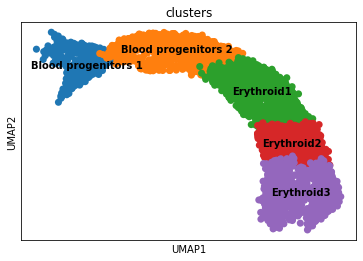

In [6]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data', show = False, ax = ax)
plt.savefig(results_path + data_name + 'UMAP_clusters.pdf')

As usual in the scvi-tools workflow we register the anndata object ...

In [7]:
c2f.Cell2fate_DynamicalModel_SequentialModules_LinearDependent.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced',
                                           batch_key = 'sequencing.batch')

... and initialize the model:

In [8]:
mod = c2f.Cell2fate_DynamicalModel_SequentialModules_LinearDependent(adata, n_modules = n_modules)

Let's have a look at the anndata setup:

In [9]:
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.1.

Setup via `Cell2fate_DynamicalModel_SequentialModules_LinearDependent.setup_anndata` with 
arguments:

{
│   'layer': None,
│   'batch_key': 'sequencing.batch',
│   'labels_key': None,
│   'unspliced_label': 'unspliced',
│   'spliced_label': 'spliced',
│   'cluster_label': None
}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 4623  │
│      n_vars      │ 3000  │
│     n_batch      │   3   │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  unspliced   │ adata.layers['unspliced'] │
│   spliced    │  adata.layers['spliced']  │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                        batch State Registry                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sequencing.batch'] │     1      │          0          │
│                               │     2      │          1          │
│                               │     3      │          2          │
└───────────────────────────────┴────────────┴─────────────────────┘

Training the model:

In [10]:
mod.train(use_gpu=True, max_epochs = 5000, lr = 0.001)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5000/5000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:50:48<00:00,  1.33s/it, v_num=1, elbo_train=6.31e+7]


We plot training history over multiple windows to effectively assess convergence (which is not reached here but it is close.)

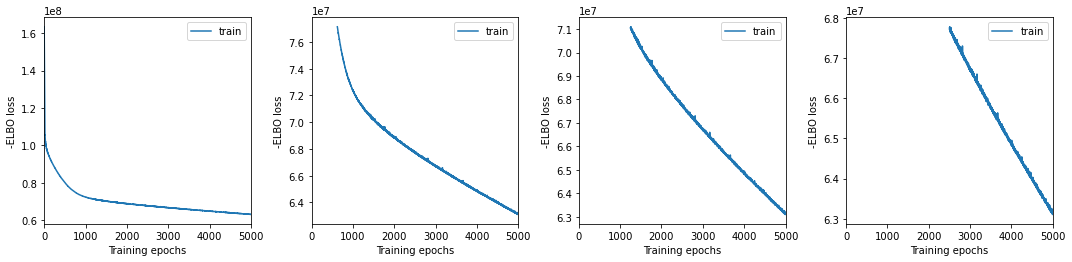

In [11]:
mod.view_history()

Here we export the model posterior to the anndata object:

In [12]:
adata = mod.export_posterior(adata)

sample_kwargs['batch_size'] 4623
Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:12<00:00,  2.28it/s]


One of the interesting parameter posteriors that was saved to the anndata object is the differentiation time:

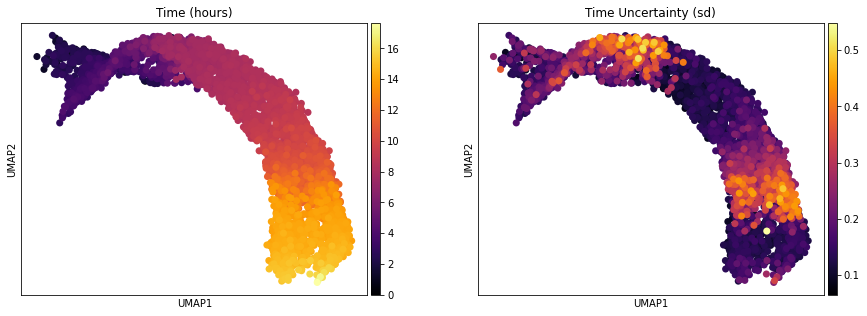

In [13]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
sc.pl.umap(adata, color = ['Time (hours)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[0])
sc.pl.umap(adata, color = ['Time Uncertainty (sd)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[1])
plt.savefig(results_path + data_name + 'UMAP_Time.pdf')

We can compute some module statistics to visualize the activity of the underlying modules:

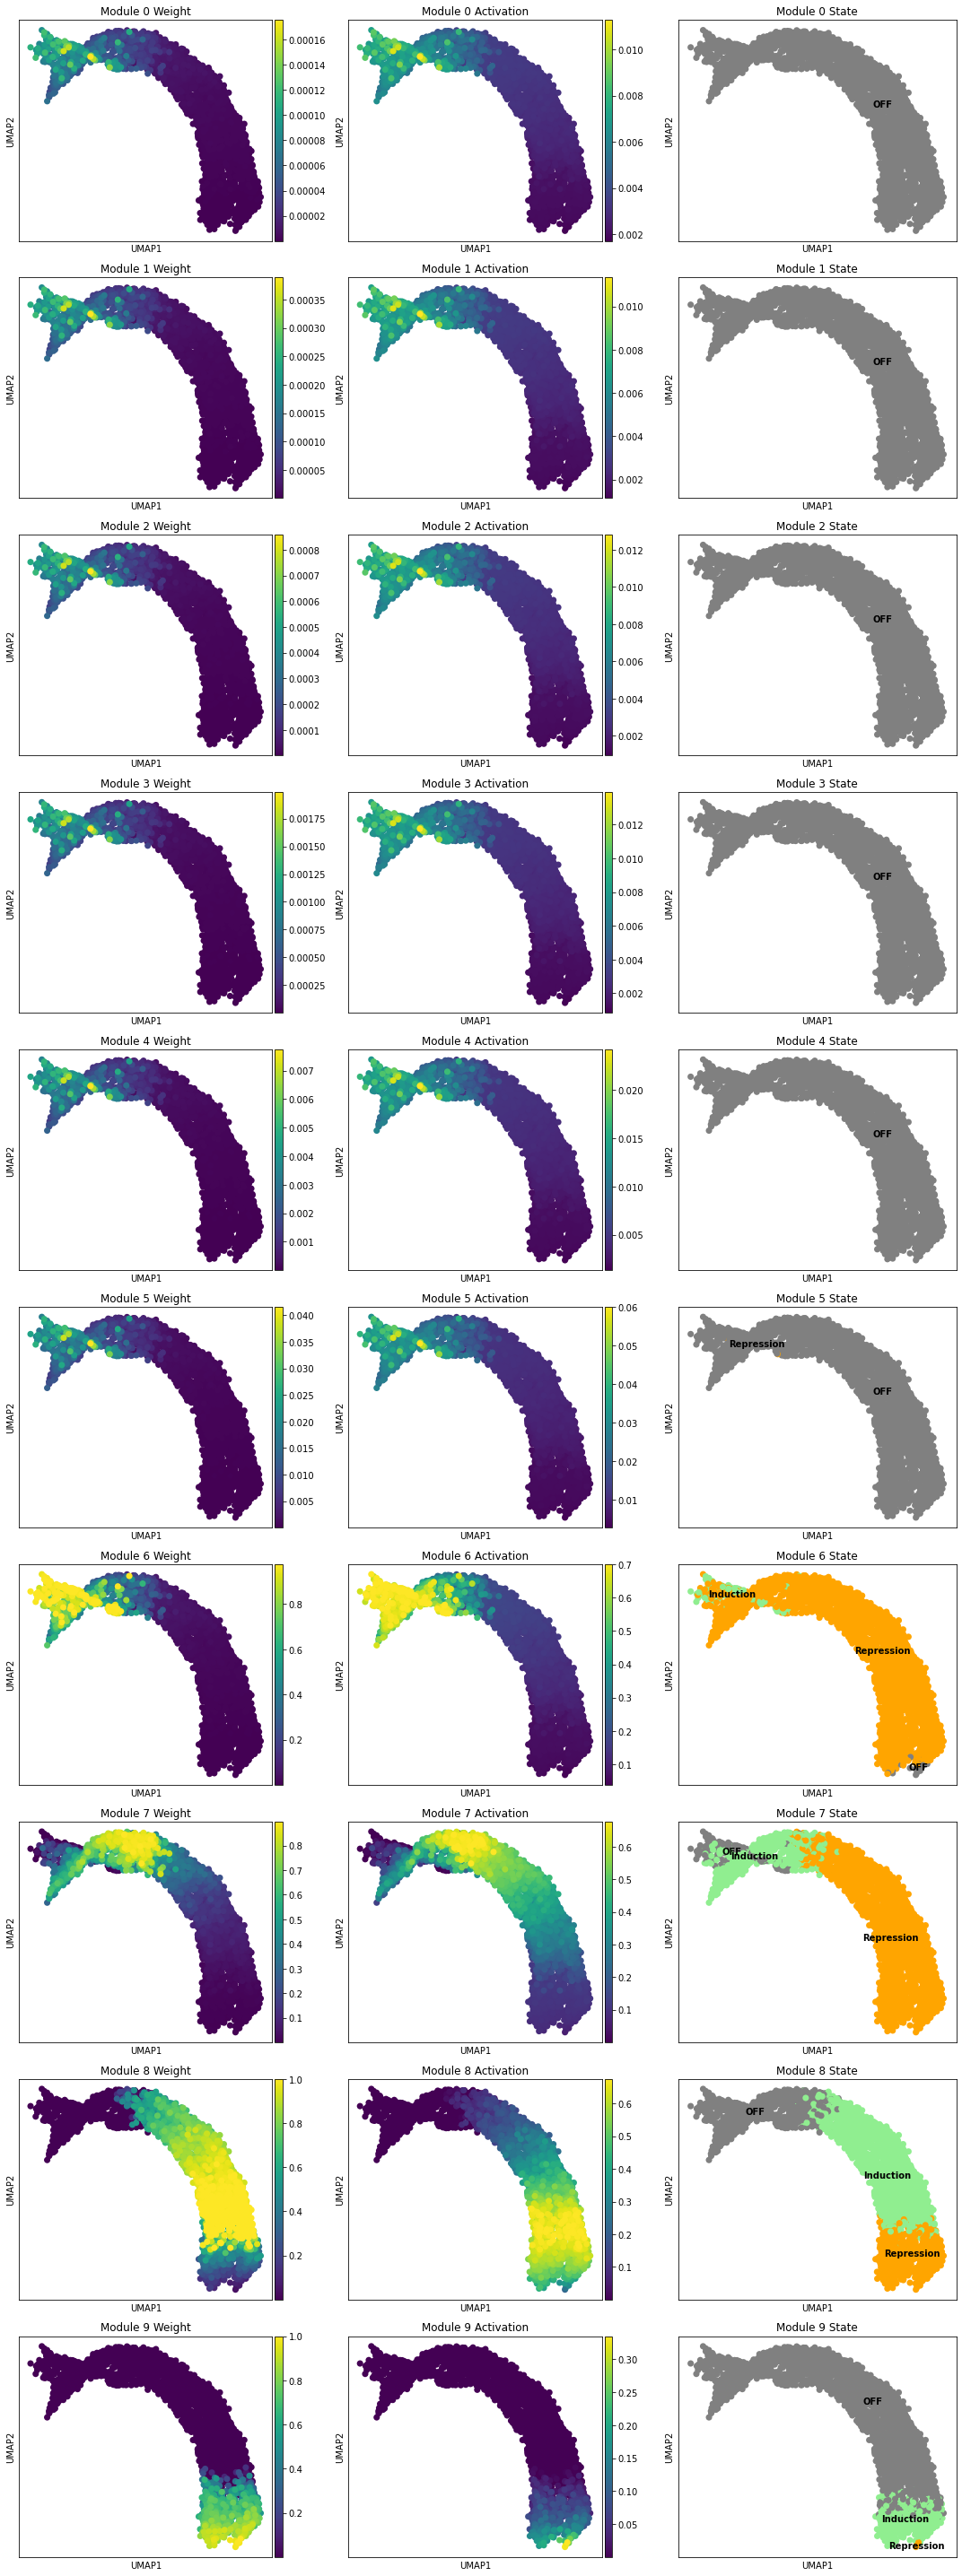

In [14]:
adata = mod.compute_module_summary_statistics(adata)
mod.plot_module_summary_statistics(adata, save = results_path + data_name + 'module_summary_stats_plot.pdf')

Simulate knockouts:

In [55]:
pertubation = {'index': np.where(adata.var_names == 'Gata1')[0][0], 'expression': 0}

In [ ]:
time_range = {'start': 0, 'end': }

In [ ]:
def simulatePertubation(mod, pertubation, time_range):
    
        # ===================== Kinetic Rates ======================= #
        # Splicing rate:
        splicing_alpha = pyro.sample('splicing_alpha',
                              dist.Gamma(self.splicing_rate_alpha_hyp_prior_alpha,
                              self.splicing_rate_alpha_hyp_prior_alpha/self.splicing_rate_alpha_hyp_prior_mean))
        splicing_mean = pyro.sample('splicing_mean',
                              dist.Gamma(self.splicing_rate_mean_hyp_prior_alpha,
                              self.splicing_rate_mean_hyp_prior_alpha/self.splicing_rate_mean_hyp_prior_mean))
        beta_g = pyro.sample('beta_g', dist.Gamma(splicing_alpha, splicing_alpha/splicing_mean).expand([1,self.n_vars]).to_event(2))
        # Degredation rate:
        degredation_alpha = pyro.sample('degredation_alpha',
                              dist.Gamma(self.degredation_rate_alpha_hyp_prior_alpha,
                              self.degredation_rate_alpha_hyp_prior_alpha/self.degredation_rate_alpha_hyp_prior_mean))
        degredation_mean = pyro.sample('degredation_mean',
                              dist.Gamma(self.degredation_rate_mean_hyp_prior_alpha,
                              self.degredation_rate_mean_hyp_prior_alpha/self.degredation_rate_mean_hyp_prior_mean))
        gamma_g = pyro.sample('gamma_g', dist.Gamma(degredation_alpha, degredation_alpha/degredation_mean).expand([1,self.n_vars]).to_event(2))
        # Transcription rate contribution of each module:
        factor_level_g = pyro.sample(
            "factor_level_g",
            dist.Gamma(self.factor_prior_alpha, self.factor_prior_beta)
            .expand([1, self.n_vars])
            .to_event(2)
        )
        # Sequential dependence between modules:
        # First module
        g_fg_list = [] #(g_fg corresponds to module's spliced counts in steady state)
        g_fg_list += [pyro.sample( 
            "g_0g",
            dist.Gamma(
                self.factor_states_per_gene / self.n_factors_torch,
                self.ones / factor_level_g,
            )
            .expand([1, self.n_vars])
            .to_event(2)
        )]
        # Linear dependence between modules:
        X_gg = pyro.sample( 
            "X_gg",
            dist.Gamma(
                self.one/self.n_vars,
                self.one,
            )
            .expand([self.n_vars, self.n_vars])
            .to_event(2)
        )
        for m in range(1, self.n_modules):
            mean = torch.einsum("ij,kj->kj", X_gg, g_fg_list[-1]) + 10**(-5) # i.e. function that links modules over time
            alpha = 0.1
            g_fg_list += [pyro.sample( # (g_fg corresponds to module's spliced counts in steady state)
            "g_" + str(m) + 'g',
            dist.Gamma(
                self.one*alpha,
                self.one*alpha/mean,
            )
            .expand([1, self.n_vars])
            .to_event(2))]
        g_fg = torch.stack(g_fg_list, axis = 0)
        A_mgON = pyro.deterministic('A_mgON', g_fg*gamma_g) # (transform from spliced counts to transcription rate)
        A_mgOFF = self.alpha_OFFg        
        # Activation and Deactivation rate:
        lam_mu = pyro.sample('lam_mu', dist.Gamma(G_a(self.activation_rate_mean_hyp_prior_mean, self.activation_rate_mean_hyp_prior_sd),
                                            G_b(self.activation_rate_mean_hyp_prior_mean, self.activation_rate_mean_hyp_prior_sd)))
        lam_sd = pyro.sample('lam_sd', dist.Gamma(G_a(self.activation_rate_sd_hyp_prior_mean, self.activation_rate_sd_hyp_prior_sd),
                                            G_b(self.activation_rate_sd_hyp_prior_mean, self.activation_rate_sd_hyp_prior_sd)))
        lam_m_mu = pyro.sample('lam_m_mu', dist.Gamma(G_a(lam_mu, lam_sd),
                                            G_b(lam_mu, lam_sd)).expand([self.n_modules, 1, 1]).to_event(3))
        lam_mi = pyro.sample('lam_mi', dist.Gamma(G_a(lam_m_mu, lam_m_mu*0.05),
                                            G_b(lam_m_mu, lam_m_mu*0.05)).expand([self.n_modules, 1, 2]).to_event(3))
        
        # =====================Time======================= #
        # Global time for each cell:
        T_max = pyro.sample('Tmax', dist.Gamma(G_a(self.Tmax_mean, self.Tmax_sd), G_b(self.Tmax_mean, self.Tmax_sd)))
        t_c_loc = pyro.sample('t_c_loc', dist.Gamma(self.one, self.one/0.5))
        t_c_scale = pyro.sample('t_c_scale', dist.Gamma(self.one, self.one/0.25))
        with obs_plate:
            t_c = pyro.sample('t_c', dist.Normal(t_c_loc, t_c_scale).expand([batch_size, 1, 1]))
        T_c = pyro.deterministic('T_c', t_c*T_max)
        t_delta = pyro.sample('t_delta', dist.Gamma(self.one*20, self.one * 20 *self.n_modules_torch).
                              expand([self.n_modules]).to_event(1))
        t_mON = torch.cumsum(torch.concat([self.zero.unsqueeze(0), t_delta[:-1]]), dim = 0).unsqueeze(0).unsqueeze(0)
        T_mON = pyro.deterministic('T_mON', T_max*t_mON)
        # Global switch off time for each module:
        t_mOFF = torch.cumsum(t_delta, 0).unsqueeze(0).unsqueeze(0)
        T_mOFF = pyro.deterministic('T_mOFF', T_max*t_mOFF)
        
        # =========== Mean expression according to RNAvelocity model ======================= #
        # (summing over all independent modules)
        mu_total = torch.stack([self.zeros[idx,...], self.zeros[idx,...]], axis = -1)
        for m in range(self.n_modules):
            mu_total += mu_mRNA_continousAlpha_globalTime_twoStates(
                A_mgON[m,:], A_mgOFF, beta_g, gamma_g, lam_mi[m,...], T_c[:,:,0], T_mON[:,:,m], T_mOFF[:,:,m], self.zeros[idx,...])
        mu_expression = pyro.deterministic('mu_expression', mu_total)
        
        # =============Detection efficiency of spliced and unspliced counts =============== #
        # Cell specific relative detection efficiency with hierarchical prior across batches:
        detection_mean_y_e = pyro.sample(
            "detection_mean_y_e",
            dist.Beta(
                self.ones * self.detection_mean_hyp_prior_alpha,
                self.ones * self.detection_mean_hyp_prior_beta,
            )
            .expand([self.n_batch, 1])
            .to_event(2),
        )
        detection_hyp_prior_alpha = pyro.deterministic(
            "detection_hyp_prior_alpha",
            self.detection_hyp_prior_alpha,
        )

        beta = detection_hyp_prior_alpha / (obs2sample @ detection_mean_y_e)
        with obs_plate:
            detection_y_c = pyro.sample(
                "detection_y_c",
                dist.Gamma(detection_hyp_prior_alpha.unsqueeze(dim=-1), beta.unsqueeze(dim=-1)),
            )  # (self.n_obs, 1)        
        
        # Global relative detection efficiency between spliced and unspliced counts
        detection_y_i = pyro.sample(
            "detection_y_i",
            dist.Gamma(
                self.ones * self.detection_i_prior_alpha,
                self.ones * self.detection_i_prior_alpha,
            )
            .expand([1, 1, 2]).to_event(3)
        )
        
        # Gene specific relative detection efficiency between spliced and unspliced counts
        detection_y_gi = pyro.sample(
            "detection_y_gi",
            dist.Gamma(
                self.ones * self.detection_gi_prior_alpha,
                self.ones * self.detection_gi_prior_alpha,
            )
            .expand([1, self.n_vars, 2])
            .to_event(3),
        )
        
        # =======Gene-specific additive component (Ambient RNA/ "Soup") for spliced and unspliced counts ====== #
        # Independently sampled for spliced and unspliced counts:
        s_g_gene_add_alpha_hyp = pyro.sample(
            "s_g_gene_add_alpha_hyp",
            dist.Gamma(self.gene_add_alpha_hyp_prior_alpha, self.gene_add_alpha_hyp_prior_beta).expand([2]).to_event(1),
        )
        s_g_gene_add_mean = pyro.sample(
            "s_g_gene_add_mean",
            dist.Gamma(
                self.gene_add_mean_hyp_prior_alpha,
                self.gene_add_mean_hyp_prior_beta,
            )
            .expand([self.n_batch, 1, 2])
            .to_event(3),
        ) 
        s_g_gene_add_alpha_e_inv = pyro.sample(
            "s_g_gene_add_alpha_e_inv",
            dist.Exponential(s_g_gene_add_alpha_hyp).expand([self.n_batch, 1, 2]).to_event(3),
        )
        s_g_gene_add_alpha_e = self.ones / s_g_gene_add_alpha_e_inv.pow(2)
        s_g_gene_add = pyro.sample(
            "s_g_gene_add",
            dist.Gamma(s_g_gene_add_alpha_e, s_g_gene_add_alpha_e / s_g_gene_add_mean)
            .expand([self.n_batch, self.n_vars, 2])
            .to_event(3),
        )

        # =========Gene-specific overdispersion of spliced and unspliced counts ============== #
        # Overdispersion of unspliced counts:
        stochastic_v_ag_hyp = pyro.sample(
        "stochastic_v_ag_hyp",
        dist.Gamma(
            self.stochastic_v_ag_hyp_prior_alpha,
            self.stochastic_v_ag_hyp_prior_beta,
        ).expand([1, 2]).to_event(2))
        stochastic_v_ag_inv = pyro.sample(
            "stochastic_v_ag_inv",
            dist.Exponential(stochastic_v_ag_hyp)
            .expand([1, self.n_vars, 2]).to_event(3),
        ) 
        stochastic_v_ag = (self.ones / stochastic_v_ag_inv.pow(2))        

        # =====================Expected expression ======================= #
        # biological expression
        mu = pyro.deterministic('mu', (mu_expression + torch.einsum('cbi,bgi->cgi', obs2sample.unsqueeze(dim=-1), s_g_gene_add)) * \
        detection_y_c * detection_y_i * detection_y_gi)
        
        # =====================DATA likelihood ======================= #
        # Likelihood (sampling distribution) of data_target & add overdispersion via NegativeBinomial
        with obs_plate:
            pyro.sample("data_target", dist.GammaPoisson(concentration= stochastic_v_ag,
                       rate= stochastic_v_ag / mu), obs=torch.stack([u_data, s_data], axis = 2))

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
X_gg = pd.DataFrame(mod.samples['post_sample_means']['X_gg'], columns = adata.var_names, index = adata.var_names)
X_gg.loc[('Gata1', 'Hba-x', 'Nudt4'),('Gata1', 'Hba-x', 'Nudt4')]

index,Gata1,Hba-x,Nudt4
index,,,
Gata1,0.003380,0.018021,0.003041
Hba-x,0.000458,0.003733,0.004383
Nudt4,0.000432,0.008764,0.004453


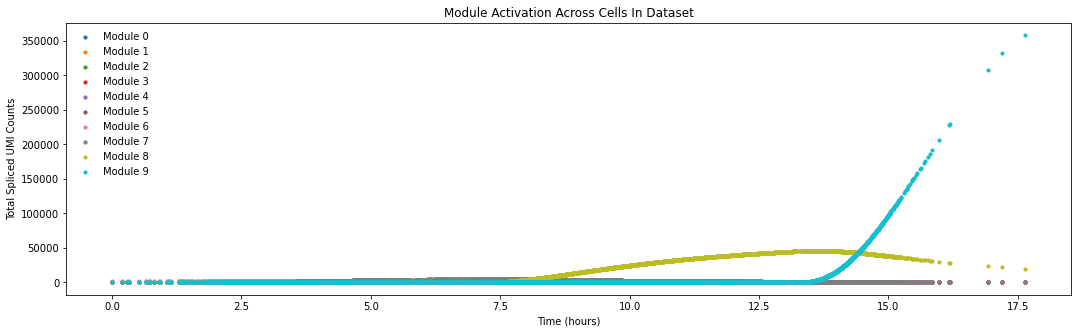

In [15]:
mod.compare_module_activation(adata, chosen_modules = [0,1,2,3,4,5,6,7,8,9],
                         save = results_path + data_name + 'module_activation_comparison.pdf')

And of course we can make the usual visualization of total RNAvelocity on a UMAP:

In [16]:
# mod.compute_and_plot_total_velocity(adata, save = results_path + data_name + 'total_velocity_plots.png')

In [17]:
# import matplotlib.pyplot as plt
# import scvelo as scv
# fix, ax = plt.subplots(1, 1, figsize = (8, 6))
# scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='Velocity',
#                                  show = False, ax = ax, legend_fontsize = 13)
# plt.savefig(results_path + data_name + 'total_velocity_plots.png')

Technical variables usually show lower detection efficiency and higher noise (= lower overdispersion parameter) for unspliced counts:

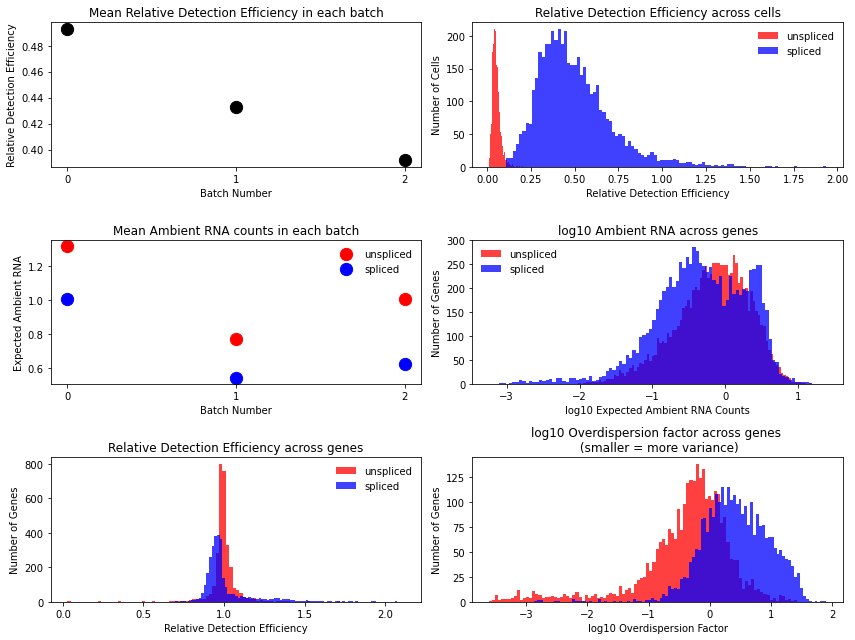

In [18]:
mod.plot_technical_variables(adata, save = results_path + data_name + 'technical_variables_overview_plot.pdf')

This is how to have a look at the various rate parameters the optimization converged to:

In [19]:
print('A_mgON mean:', np.mean(mod.samples['post_sample_means']['A_mgON']))
print('gamma_g mean:', np.mean(mod.samples['post_sample_means']['gamma_g']))
print('beta_g mean:', np.mean(mod.samples['post_sample_means']['beta_g']))
print('lam_mi, all modules: \n \n', np.round(mod.samples['post_sample_means']['lam_mi'],2))

A_mgON mean: 9.402584
gamma_g mean: 0.6713125
beta_g mean: 1.0690128
lam_mi, all modules: 
 
 [[[ 2.37  2.11]]

 [[ 2.3   2.11]]

 [[ 2.34  2.13]]

 [[ 2.45  2.35]]

 [[ 2.74  2.17]]

 [[ 3.41  2.41]]

 [[ 4.34  2.33]]

 [[22.88 27.  ]]

 [[ 3.11  2.93]]

 [[ 1.31  1.51]]]


This method returns orders the genes and TFs in each module from most to least enriched. And it also performs gene set enrichment analysis:

In [20]:
tab, all_results = mod.get_module_top_features(adata, p_adj_cutoff=0.01, background = adata.var_names)
tab.to_csv(results_path + data_name + 'module_top_features_table.csv')

KeyboardInterrupt: 

In [ ]:
tab

Plot transcription rate for MURK genes:

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
def mu_alpha(alpha_new, alpha_old, tau, lam):
    '''Calculates transcription rate as a function of new target transcription rate,
    old transcription rate at changepoint, time since change point and rate of exponential change process'''
    return (alpha_new - alpha_old) * (1 - torch.exp(-lam*tau)) + alpha_old

def mu_mRNA_continuousAlpha_withPlates(alpha, beta, gamma, tau, u0, s0, delta_alpha, lam):
    ''' Calculates expected value of spliced and unspliced counts as a function of rates, latent time, initial states,
    difference to transcription rate in previous state and rate of exponential change process between states.'''
    
    mu_u = u0*torch.exp(-beta*tau) + (alpha/beta)* (1 - torch.exp(-beta*tau)) + delta_alpha/(beta-lam+10**(-5))*(torch.exp(-beta*tau) - torch.exp(-lam*tau))
    mu_s = (s0*torch.exp(-gamma*tau) + 
    alpha/gamma * (1 - torch.exp(-gamma*tau)) +
    (alpha - beta * u0)/(gamma - beta+10**(-5)) * (torch.exp(-gamma*tau) - torch.exp(-beta*tau)) +
    (delta_alpha*beta)/((beta - lam+10**(-5))*(gamma - beta+10**(-5))) * (torch.exp(-beta*tau) - torch.exp(-gamma*tau))-
    (delta_alpha*beta)/((beta - lam+10**(-5))*(gamma - lam+10**(-5))) * (torch.exp(-lam*tau) - torch.exp(-gamma*tau)))

    return torch.stack([mu_u, mu_s], axis = -1)

def mu_mRNA_continousAlpha_globalTime_twoStates(alpha_ON, alpha_OFF, beta, gamma, lam_gi, T_c, T_gON, T_gOFF, Zeros):
    '''Calculates expected value of spliced and unspliced counts as a function of rates,
    global latent time, initial states and global switch times between two states'''
    n_cells = T_c.shape[-2]
    n_genes = alpha_ON.shape[-1]
    tau = torch.clip(T_c - T_gON, min = 10**(-5))
    t0 = T_gOFF - T_gON
    # Transcription rate in each cell for each gene:
    boolean = (tau < t0).reshape(n_cells, 1)
    alpha_cg = alpha_ON*boolean + alpha_OFF*~boolean
    # Time since changepoint for each cell and gene:
    tau_cg = tau*boolean + (tau - t0)*~boolean
    # Initial condition for each cell and gene:
    lam_g = ~boolean*lam_gi[:,1] + boolean*lam_gi[:,0]
    initial_state = mu_mRNA_continuousAlpha_withPlates(alpha_ON, beta, gamma, t0,
                                                       Zeros, Zeros, alpha_ON-alpha_OFF, lam_gi[:,0])
    initial_alpha = mu_alpha(alpha_ON, alpha_OFF, t0, lam_gi[:,0])
    u0_g = 10**(-5) + ~boolean*initial_state[:,:,0]
    s0_g = 10**(-5) + ~boolean*initial_state[:,:,1]
    delta_alpha = ~boolean*initial_alpha*(-1) + boolean*alpha_ON*(1)
    alpha_0 = alpha_OFF + ~boolean*initial_alpha
    # Unspliced and spliced count variance for each gene in each cell:
    mu_RNAvelocity = torch.clip(mu_mRNA_continuousAlpha_withPlates(alpha_cg, beta, gamma, tau_cg,
                                                         u0_g, s0_g, delta_alpha, lam_g), min = 10**(-5))
    alpha_0 = alpha_OFF + ~boolean*initial_alpha
    alpha_cg = mu_alpha(alpha_cg, alpha_0, tau_cg, lam_g)
    return mu_RNAvelocity, alpha_cg

In [ ]:
n_cells = len(adata.obs_names)
n_vars = len(adata.var_names)

In [ ]:
mu_m = []
alpha_cg = []

for m in range(n_modules):
    print(m)
    mu, alpha, = mu_mRNA_continousAlpha_globalTime_twoStates(
                torch.tensor(mod.samples['post_sample_means']['A_mgON'][m,:]),
                torch.tensor(0., dtype = torch.float),
                torch.tensor(mod.samples['post_sample_means']['beta_g']),
                torch.tensor(mod.samples['post_sample_means']['gamma_g']),
                torch.tensor(mod.samples['post_sample_means']['lam_mi'][m,...]),
                torch.tensor(mod.samples['post_sample_means']['T_c'][...,0]),
                torch.tensor(mod.samples['post_sample_means']['T_mON'][...,m]),
                torch.tensor(mod.samples['post_sample_means']['T_mOFF'][...,m]),
                torch.zeros((n_cells, n_vars)))
    mu_m += [m]
    alpha_cg += [alpha]
alpha = np.stack(alpha_cg, axis = 0)

In [ ]:
MURK_genes = ['Hba-x', 'Smim1', 'Dcxr', 'Cox6b2', 'Gypa', 'Cpox', 'Hbb-bh1', 'Nudt4', 'Hbb-bt']

In [ ]:
fig, ax = plt.subplots(1,3,figsize = (15, 3))
count = 0
for g in [0,7,1]:
    ax[count].scatter(mod.samples['post_sample_means']['T_c'][:,0,0], 
                np.sum(alpha_cg, axis = 0)[:, np.where(adata.var_names == MURK_genes[g])[0][0]],
               c = 'black')
    ax[count].set_title(MURK_genes[g])
    ax[count].set_xlabel('Time')
    ax[count].set_ylabel('Transcription Rate')
    count += 1
plt.savefig(results_path + data_name + 'MURK_geneTranscription_rate.pdf', bbox_inches="tight")